# **2110433 - Computer Vision (2023/2)**
#**Lab 9 - Modern Object Detection [Homework]** <br>
In this lab, we will learn how to use MMDetection to perform object detection in the provided real world dataset using PyTorch. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer.

**Collaboration is encouraged in this course.** You must turn in your own write ups of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- ...
- ...


# Assignment 1 : Parasite Detection
![alt text](https://icip2022challenge.piclab.ai/wp-content/uploads/2022/01/parasite_egg_11_with_size.png)

In this assignment you have to replace YOUR_STUDENT_ID_WITH21 variable with your student id (in integer). There will be 2 sets of data: train and test

By using the knowledge from the lab and lecture, you have to train object detection model and tested on unknown label dataset!



Scoreboard URL : https://www.piclab.ai/classes/cv2023/lab9/scoreboard

### Hints
- The parasite dataset was created using COCO dataset format
- If you use MMDetection, the dataset is ready to use
- If you want to use Ultralytics, you have to format to YOLO dataset format (use Fiftyone!)


## GPU Status Check

In [1]:
!nvidia-smi

Sat Mar 30 01:15:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        On  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P8              26W / 340W |    511MiB / 16376MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and inspect parasite dataset

In [2]:
# !pip install --upgrade gdown
# !gdown https://drive.google.com/uc?id=1RVluBzZvJ8mWwA5AuB2PklbaoK60uPMF
# !gdown https://drive.google.com/uc?id=1kvBxmC1o0vE2ef2CJqhLaj9V4TD72oW3
# !unzip parasite_train.zip
# !unzip parasite_test.zip

## Your model description goes here: ###
WRITE HERE

### Dataset Exploration
We will use pycocotools to explore this dataset.

In [3]:
from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
trainLabelFile='./parasite_train/labels.json'
# initialize COCO api for instance annotations
trainCOCOBinding = COCO(trainLabelFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


COCO categories: 
Capillaria philippinensis, Enterobius vermicularis, Hymenolepis diminuta, Hymenolepis nana, Paragonimus spp

['Capillaria philippinensis', 'Enterobius vermicularis', 'Hymenolepis diminuta', 'Hymenolepis nana', 'Paragonimus spp']
[601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 75

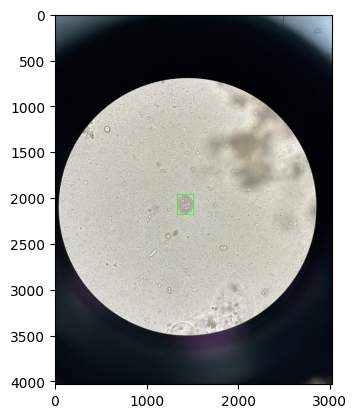

In [5]:
#display COCO categories and supercategories
cats = trainCOCOBinding.loadCats(trainCOCOBinding.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))
print(nms)

# get all images containing given categories, select one at random
catIds = trainCOCOBinding.getCatIds(catNms=['Hymenolepis diminuta',]);
imgIds = trainCOCOBinding.getImgIds(catIds=catIds );
print([id for id in imgIds])

randomImgId = np.random.randint(0,len(imgIds))
sampleImageData = trainCOCOBinding.loadImgs(randomImgId)[0]

print('Image Data >>', sampleImageData)

sampleImage = cv2.imread('parasite_train/data/'+sampleImageData['file_name'])

annIds = trainCOCOBinding.getAnnIds(imgIds=randomImgId, iscrowd=None)
boxes = trainCOCOBinding.loadAnns(annIds)
print('Box Data', boxes)

for box in boxes:
  x,y,w,h = box['bbox']
  cv2.rectangle(sampleImage, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 5)

sampleImage = cv2.cvtColor(sampleImage, cv2.COLOR_BGR2RGB)

plt.imshow(sampleImage)
plt.show()

### Training

In [1]:
from ultralytics import YOLO
import torch

torch.cuda.empty_cache()

yolo_model = YOLO('yolov8l.yaml').load('yolov8l.pt')
yolo_model = yolo_model.cuda()
config = {
    'data' : 'dataset.yaml',
    'epochs' : 50,
    'batch' : 16,
    'device' : 0,
    'workers' : 20,
    'verbose' : True,
    'max_det' : 1,
    'imgsz' : 800
}

Transferred 595/595 items from pretrained weights


In [2]:
yolo_model.train(**config)

Ultralytics YOLOv8.1.37 🚀 Python-3.11.8 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16071MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.yaml, data=dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=0, workers=20, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=1, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/train/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
val: Scanning /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/train/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 20 dataloader workers
Logging results to runs/detect/train8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      15.3G     0.5276      2.297      0.893         16        800: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.98it/s]

                   all       1000       1000      0.664       0.14      0.363      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      15.9G     0.6045      1.088     0.9587         13        800: 100%|██████████| 63/63 [00:22<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]

                   all       1000       1000     0.0975      0.024      0.048     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      15.9G     0.6402      1.013     0.9977         19        800: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.95it/s]

                   all       1000       1000      0.603      0.343      0.429      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      15.9G     0.6452     0.8602          1         11        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]

                   all       1000       1000      0.882      0.632      0.773      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      15.8G     0.6298      0.796      1.006         13        800: 100%|██████████| 63/63 [00:22<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.89it/s]

                   all       1000       1000      0.822      0.713      0.801      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      15.9G     0.6279     0.7038     0.9998         15        800: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]

                   all       1000       1000      0.834      0.691      0.797       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      15.8G     0.5406     0.5986     0.9438          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]

                   all       1000       1000       0.85      0.813      0.881      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      15.4G     0.5458     0.5636      0.941         12        800: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]

                   all       1000       1000      0.934      0.868       0.93      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      15.9G     0.5394     0.5646      0.946         13        800: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]

                   all       1000       1000      0.898      0.886      0.915      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      15.3G     0.5213     0.5085      0.933         15        800: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]

                   all       1000       1000      0.961      0.955      0.972        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      15.3G     0.5092     0.4839     0.9256         18        800: 100%|██████████| 63/63 [00:23<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]

                   all       1000       1000      0.942      0.927      0.957      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      15.3G      0.511     0.4795     0.9318         15        800: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]

                   all       1000       1000       0.89      0.851      0.902      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      15.7G     0.4824     0.4708     0.9164         22        800: 100%|██████████| 63/63 [00:23<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1000       1000      0.981      0.979      0.985      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      15.9G     0.4901     0.4261     0.9166         15        800: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]

                   all       1000       1000       0.91       0.88      0.929       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      15.3G     0.4586     0.4169     0.9035         12        800: 100%|██████████| 63/63 [00:24<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]

                   all       1000       1000      0.948       0.94      0.964      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      15.4G     0.4521     0.4078     0.8898         10        800: 100%|██████████| 63/63 [00:23<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]

                   all       1000       1000      0.921      0.902      0.934      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      15.9G     0.4497     0.4072     0.8978         14        800: 100%|██████████| 63/63 [00:23<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]

                   all       1000       1000      0.948      0.943      0.964      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      15.9G     0.4431     0.3988     0.8926         11        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]

                   all       1000       1000      0.896      0.869      0.919      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      15.7G     0.4271     0.3857      0.882         16        800: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]

                   all       1000       1000      0.991       0.99      0.992      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      15.3G     0.4188     0.3463     0.8861         13        800: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1000       1000      0.981      0.981      0.988      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      15.9G     0.4232     0.3643     0.8848         10        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]

                   all       1000       1000      0.986      0.986      0.989      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      15.9G     0.4099     0.3536     0.8808         22        800: 100%|██████████| 63/63 [00:23<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]

                   all       1000       1000      0.987      0.986      0.988      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      15.9G     0.4031     0.3376     0.8782         16        800: 100%|██████████| 63/63 [00:23<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]

                   all       1000       1000      0.988      0.988       0.99      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      15.9G     0.4025      0.336     0.8695         13        800: 100%|██████████| 63/63 [00:23<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]

                   all       1000       1000      0.985      0.984      0.989      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      15.7G     0.3931     0.3201     0.8639         10        800: 100%|██████████| 63/63 [00:23<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]

                   all       1000       1000      0.985      0.982      0.989      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      15.9G     0.3928     0.3164     0.8659         19        800: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1000       1000      0.969      0.966      0.979      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      15.9G     0.3819     0.3079      0.861         12        800: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]

                   all       1000       1000      0.992      0.992      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      15.9G     0.3677     0.2893     0.8579         13        800: 100%|██████████| 63/63 [00:23<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]

                   all       1000       1000      0.991      0.991      0.992      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      15.8G     0.3717     0.3003     0.8597         18        800: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1000       1000      0.993      0.991      0.992      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      15.9G     0.3822     0.2879     0.8594         25        800: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]

                   all       1000       1000      0.998      0.998      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      15.9G      0.356     0.2767     0.8509         11        800: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]

                   all       1000       1000      0.993      0.992      0.993      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      15.9G      0.368     0.2824     0.8559         17        800: 100%|██████████| 63/63 [00:23<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1000       1000      0.983      0.982      0.988      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      15.8G     0.3618     0.2903     0.8552         16        800: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]

                   all       1000       1000       0.97      0.966      0.978      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      15.9G     0.3399      0.266     0.8489         12        800: 100%|██████████| 63/63 [00:23<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]

                   all       1000       1000      0.998      0.998      0.994      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      15.9G     0.3417     0.2568     0.8406         11        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]

                   all       1000       1000      0.996      0.996      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      15.9G     0.3301     0.2552     0.8428         14        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]

                   all       1000       1000      0.994      0.994      0.993      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      15.8G     0.3402     0.2432     0.8478         14        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]

                   all       1000       1000      0.999      0.999      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      15.9G     0.3326     0.2435     0.8402         15        800: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]

                   all       1000       1000          1          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      15.9G     0.3295     0.2383     0.8408         15        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]

                   all       1000       1000      0.998      0.998      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      15.9G     0.3196     0.2318     0.8479         14        800: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]

                   all       1000       1000      0.998      0.997      0.995       0.98


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      15.8G     0.2839     0.2151     0.8071          8        800: 100%|██████████| 63/63 [00:24<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]

                   all       1000       1000      0.998      0.998      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      15.9G     0.2799     0.2046     0.8049          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]

                   all       1000       1000      0.996      0.996      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      15.9G     0.2641     0.1954     0.8031          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]

                   all       1000       1000      0.998      0.998      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      15.9G     0.2657     0.1938     0.8123          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1000       1000      0.999      0.999      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      15.9G      0.263     0.1859     0.8061          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]

                   all       1000       1000      0.999      0.999      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      15.9G     0.2526     0.1777     0.8009          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]

                   all       1000       1000      0.998      0.998      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      15.9G     0.2547     0.1736     0.7983          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]

                   all       1000       1000      0.999      0.999      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      15.9G     0.2468     0.1741     0.8042          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]

                   all       1000       1000      0.999      0.999      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      15.8G     0.2452     0.1721     0.8022          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]

                   all       1000       1000      0.999      0.999      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      15.9G     0.2373     0.1675     0.7973          8        800: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]

                   all       1000       1000      0.999      0.999      0.994      0.986



50 epochs completed in 0.438 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 87.7MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.11.8 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16071MiB)
YOLOv8l summary (fused): 268 layers, 43610463 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


                   all       1000       1000      0.999      0.999      0.995      0.986
Capillaria philippinensis       1000        200          1          1      0.995      0.967
Enterobius vermicularis       1000        200          1          1      0.995      0.988
  Hymenolepis diminuta       1000        200          1          1      0.995      0.994
      Hymenolepis nana       1000        200          1          1      0.995      0.988
       Paragonimus spp       1000        200      0.995      0.995      0.994      0.994
Speed: 0.1ms preprocess, 5.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x71b88d07a390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

### Inference on test set!

In [6]:
# train8 l-50
bestModel = YOLO('runs/detect/train8/weights/best.pt')

In [7]:
a = bestModel('./test/data/Hymenolepis nana_0727.jpg')
print(a[0].boxes)


image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Hymenolepis nana_0727.jpg: 480x800 1 Hymenolepis nana, 65.6ms
Speed: 1.2ms preprocess, 65.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 800)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3.], device='cuda:0')
conf: tensor([0.9612], device='cuda:0')
data: tensor([[8.3348e+02, 4.6920e+02, 9.7402e+02, 5.8330e+02, 9.6122e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([1, 6])
xywh: tensor([[903.7510, 526.2502, 140.5444, 114.1053]], device='cuda:0')
xywhn: tensor([[0.4707, 0.4873, 0.0732, 0.1057]], device='cuda:0')
xyxy: tensor([[833.4788, 469.1975, 974.0233, 583.3029]], device='cuda:0')
xyxyn: tensor([[0.4341, 0.4344, 0.5073, 0.5401]], device='cuda:0')


### Submit Results

The results must follows this templates

{“annotations”: [
{“id”: int,
“file_name”: str,
“category_id”: int,
“bbox”: [x,y,width,height]}
]}



```
"categories": [
        {
            "id": 0,
            "name": "Capillaria philippinensis",
        },
        {
            "id": 1,
            "name": "Enterobius vermicularis",
        },
        {
            "id": 2,
            "name": "Hymenolepis diminuta",
        },
        {
            "id": 3,
            "name": "Hymenolepis nana",
        },
        {
            "id": 4,
            "name": "Paragonimus spp",
        }
    ]
```



In [ ]:
## Sample annotations
annotations = dict()
annotations['annotations'] = list()
annotations['annotations'] += [{"id":2, "file_name":"Hymenolepis nana_0002.jpg","category_id":3,"bbox":[549.0,459.0,178.0,151.0]}]
annotations['annotations'] += [{"id":1, "file_name":"Hymenolepis nana_0052.jpg","category_id":3,"bbox":[539.0,364.0,218.0,215.0]}]

In [22]:
# from mmdet.core import  bbox2result
import os
import numpy as np

image_dir = './test/data'

annotations = dict()
annotations['annotations'] = list()
id = 0
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)

        # print(image_path)

        ### run model
        result = bestModel(image_path, max_det=1)[0]
        cat_id = list(result.boxes.cls.cpu().numpy().astype(np.double))[0]
        bbox = list(result.boxes.xywh.cpu().numpy().astype(np.double)[0])

        coco_result = [{"id": id, "file_name": filename,"category_id": cat_id,"bbox":bbox}]
        id+=1

        annotations['annotations']+=coco_result
        # break


image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Hymenolepis nana_0002.jpg: 608x800 1 Hymenolepis nana, 9.5ms
Speed: 13.3ms preprocess, 9.5ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 800)

image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Paragonimus spp_0677.jpg: 608x800 1 Paragonimus spp, 9.2ms
Speed: 1.4ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 800)

image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Capillaria philippinensis_0177.jpg: 800x608 1 Capillaria philippinensis, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 0.5ms postprocess per image at shape (1, 3, 800, 608)

image 1/1 /home/andre/Desktop/CU_submission/chulacv2023/Lab9/student/test/data/Capillaria philippinensis_0152.jpg: 800x608 1 Capillaria philippinensis, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 0.9ms postprocess per image at shape (1, 3, 800, 608)

image 1/1 /hom

In [23]:
print(annotations)

{'annotations': [{'id': 0, 'file_name': 'Hymenolepis nana_0002.jpg', 'category_id': 3.0, 'bbox': [636.3017578125, 535.2891235351562, 182.45428466796875, 153.3541259765625]}, {'id': 1, 'file_name': 'Paragonimus spp_0677.jpg', 'category_id': 4.0, 'bbox': [644.3177490234375, 451.8797912597656, 183.83441162109375, 282.96209716796875]}, {'id': 2, 'file_name': 'Capillaria philippinensis_0177.jpg', 'category_id': 0.0, 'bbox': [974.1278076171875, 1792.0689697265625, 106.08575439453125, 140.234130859375]}, {'id': 3, 'file_name': 'Capillaria philippinensis_0152.jpg', 'category_id': 0.0, 'bbox': [996.0335693359375, 1925.1484375, 117.89739990234375, 175.4512939453125]}, {'id': 4, 'file_name': 'Capillaria philippinensis_0077.jpg', 'category_id': 0.0, 'bbox': [1127.265380859375, 1748.67431640625, 188.0906982421875, 96.3665771484375]}, {'id': 5, 'file_name': 'Capillaria philippinensis_0977.jpg', 'category_id': 0.0, 'bbox': [1024.34228515625, 1845.08154296875, 144.83978271484375, 124.5133056640625]}, 

In [25]:
import requests
import json
sendDict = { 'studentID':'6432085221', 'results':  annotations }
# sendDict = json.dumps(sendDict)
response = requests.post('https://www.piclab.ai/classes/cv2023/lab9/scoreboard/submitLab9',headers={'Content-Type': 'application/json' }, json=sendDict)
print(response.text)

{"F1Score":0.0,"mAP0.5":0.0,"mAP0.5:0.95":0.0,"mAP0.75":0.0,"mIoU":0.14239087387293523,"status":"SUCCESS"}

